In [1]:
import numpy as np # linear algebra
import numpy
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn
import sklearn
import re

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix, classification_report
from tensorflow.keras.utils import model_to_dot, plot_model
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas

pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', None)

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print("The length of train set:", len(train_df))
print("The length of test set:", len(test_df))
train_df.head(20)
#1 represents disaster tweets while 0 represents non-disaster tweets

The length of train set: 7613
The length of test set: 3263


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires,1
6,10,NaN,NaN,"#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas",1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in the woods...,1
8,14,NaN,NaN,There's an emergency evacuation happening now in the building across the street,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our area...,1


In [3]:
# get the missing test label back.

df_leak = pd.read_csv('socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[['choose_one', 'text']]

# Creating target and id
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)

# Merging target to test set
test_df = test_df.merge(df_leak, on=['id'], how='left')
#test_df = test_df.reset_index(drop=True)

print('Leaked Data Set Shape = {}'.format(test_df.shape))
print('Leaked Data Set Memory Usage = {:.2f} MB'.format(df_leak.memory_usage().sum() / 1024**2))
test_df.head()

Leaked Data Set Shape = (3263, 5)
Leaked Data Set Memory Usage = 0.09 MB


,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone.",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [4]:
# remove urls

# Define a regex pattern to match URLs
url_pattern = re.compile(r'https?://\S+')

# Define a function to remove URLs from text
def remove_urls(text):
    return url_pattern.sub('', text)

# Apply the function to the 'text' column and create a new column 'clean_text'
train_df['text'] = train_df['text'].apply(remove_urls)
test_df['text'] = test_df['text'].apply(remove_urls)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [5]:
#remove punctuation
train_df["text"] = train_df["text"].replace(to_replace=r'[^\w\s]', value='', regex=True)
test_df["text"] = test_df["text"].replace(to_replace=r'[^\w\s]', value='', regex=True)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orders in California,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1


In [6]:
# remove digits
train_df["text"] = train_df["text"].replace(to_replace=r'\d', value='', regex=True)
test_df["text"] = test_df["text"].replace(to_replace=r'\d', value='', regex=True)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,people receive wildfires evacuation orders in California,1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,1


In [7]:
# text cleaning, remove any special characters left in text for training set.
train_df['text'] = train_df["text"].str.replace('  ', ' ')
train_df['text'] = train_df["text"].str.replace('ÛÓ', '')
train_df['text'] = train_df["text"].str.replace('ÛÒ', '')
train_df['text'] = train_df["text"].str.replace('Û_', '')
train_df['text'] = train_df["text"].str.replace('ã', '')
train_df['text'] = train_df["text"].str.replace('å', '')
train_df['text'] = train_df["text"].str.replace('Ûª', '')
train_df['text'] = train_df["text"].str.replace('ÌÑ', '')
train_df['text'] = train_df["text"].str.replace('å_', '')
train_df['text'] = train_df["text"].str.replace('Ìü', '')
train_df['text'] = train_df["text"].str.replace('Ç', '')
train_df['text'] = train_df["text"].str.replace('È', '')
train_df['text'] = train_df["text"].str.replace('âÂ', '')
train_df['text'] = train_df["text"].str.replace('Ê', '')
train_df['text'] = train_df["text"].str.replace('ÛÏ', '')
train_df['text'] = train_df["text"].str.replace('Û', '')
train_df['text'] = train_df["text"].str.replace('Ì', '')
train_df['text'] = train_df["text"].str.replace('N¼', '')

train_df['text'] = train_df["text"].str.replace('North CarolinaåÊAblaze', 'North Carolina Ablaze')
train_df['text'] = train_df["text"].str.replace('CanÛªt', 'cant')
train_df['text'] = train_df["text"].str.replace('AirplaneåÊ29072015', 'airplane 29072015')
train_df['text'] = train_df["text"].str.replace('ÛÏAirplaneÛ', 'airplane')
train_df['text'] = train_df["text"].str.replace('airplaneåÊ', 'airplane')
train_df['text'] = train_df["text"].str.replace('withåÊannihilation', 'with annihilatio')
train_df['text'] = train_df["text"].str.replace('Ûminimum wageÛª', 'minimum wage')
train_df['text'] = train_df["text"].str.replace('LetÛªs', 'Lets')
train_df['text'] = train_df["text"].str.replace('InterestRateRiseÛ', 'InterestRateRise')
train_df['text'] = train_df["text"].str.replace('griefÛª', 'grief')
train_df['text'] = train_df["text"].str.replace('Ûpolitics', 'politics')
train_df['text'] = train_df["text"].str.replace('tonightÛªs', 'tonights')
train_df['text'] = train_df["text"].str.replace('ÛÏHatchet', 'Hatchet')
train_df['text'] = train_df["text"].str.replace('ControlÛ', 'Control')
train_df['text'] = train_df["text"].str.replace('ÛAvalanche', 'Avalanche')
train_df['text'] = train_df["text"].str.replace('ÊFedEx', 'FedEx')
train_df['text'] = train_df["text"].str.replace('ÛThe', 'The')
train_df['text'] = train_df["text"].str.replace('ÛInstitute', 'Institute')
train_df['text'] = train_df["text"].str.replace('ÛÏParties', 'Parties')
train_df['text'] = train_df["text"].str.replace('drivingÛ', 'driving')
train_df['text'] = train_df["text"].str.replace('Ûbody', 'body')
train_df['text'] = train_df["text"].str.replace('killsÊone', 'kills one')
train_df['text'] = train_df["text"].str.replace('ÛÏWe', 'We')
train_df['text'] = train_df["text"].str.replace('MittÛ', 'Mitt')
train_df['text'] = train_df["text"].str.replace('amp', 'and')
train_df['text'] = train_df["text"].str.replace('ÛÏThe', 'The')
train_df['text'] = train_df["text"].str.replace('casualtiesÛ', 'casualties')
train_df['text'] = train_df["text"].str.replace('Ûamino', 'amino')
train_df['text'] = train_df["text"].str.replace('HighÛ', 'High')
train_df['text'] = train_df["text"].str.replace('EntertainerÛ', 'Entertainer')
train_df['text'] = train_df["text"].str.replace('WallÛ', 'Wall')
train_df['text'] = train_df["text"].str.replace('ÛÏYou', 'You')
train_df['text'] = train_df["text"].str.replace('WarnedÛ', 'Warned')
train_df['text'] = train_df["text"].str.replace('MarketingÊMediocrity', 'Marketing Mediocrity')
train_df['text'] = train_df["text"].str.replace('ÛÏHannaPHÛ', 'Hanna')
train_df['text'] = train_df["text"].str.replace('Ûfirst', 'first')
train_df['text'] = train_df["text"].str.replace('Ûsecond', 'second')
train_df['text'] = train_df["text"].str.replace('VRAÛ', '')
train_df['text'] = train_df["text"].str.replace('RÌunion', 'union')
train_df['text'] = train_df["text"].str.replace('ÛÏAfter', 'After')
train_df['text'] = train_df["text"].str.replace('ÛDemolition', 'Demolition')
train_df['text'] = train_df["text"].str.replace('ÛIts', 'Its')
train_df['text'] = train_df["text"].str.replace('ÛÏRichmond', 'Richmond')
train_df['text'] = train_df["text"].str.replace('ÛÏLove', 'Love')
train_df['text'] = train_df["text"].str.replace('mÌ¼sica', '')
train_df['text'] = train_df["text"].str.replace('ÛDevastated', 'Devastated')
train_df['text'] = train_df["text"].str.replace('Ûim', 'im')
train_df['text'] = train_df["text"].str.replace('disasterÛ', 'disaster')
train_df['text'] = train_df["text"].str.replace('Ûhoax', 'hoax')
train_df['text'] = train_df["text"].str.replace('Ûexceptional', 'exceptional')
train_df['text'] = train_df["text"].str.replace('presidentÛ', 'president')
train_df['text'] = train_df["text"].str.replace('ÛBomb', 'Bomb')
train_df['text'] = train_df["text"].str.replace('ÛÏA', 'A')
train_df['text'] = train_df["text"].str.replace('timeÛ', 'time')
train_df['text'] = train_df["text"].str.replace('ÛÏA', 'A')
train_df['text'] = train_df["text"].str.replace('BoyÛ', 'Boy')
train_df['text'] = train_df["text"].str.replace('Ûfood', 'food')
train_df['text'] = train_df["text"].str.replace('ÛWe', 'We')
train_df['text'] = train_df["text"].str.replace('ÛBadges', 'Badges')
train_df['text'] = train_df["text"].str.replace('Ûill', 'will')
train_df['text'] = train_df["text"].str.replace('sayÛ', 'say')
train_df['text'] = train_df["text"].str.replace('youÛ', 'you')
train_df['text'] = train_df["text"].str.replace('Ûhazard', 'hazard')
train_df['text'] = train_df["text"].str.replace('ÛHeat', 'Heat')
train_df['text'] = train_df["text"].str.replace('ÛIt', 'It')
train_df['text'] = train_df["text"].str.replace('Ûplot', 'plot')
train_df['text'] = train_df["text"].str.replace('ÛHijacker', 'Hijacker')
train_df['text'] = train_df["text"].str.replace('cafÌ', 'caf')
train_df['text'] = train_df["text"].str.replace('ÛGood', 'Good')
train_df['text'] = train_df["text"].str.replace('ÛRansomware', 'Ransomware')
train_df['text'] = train_df["text"].str.replace('ÛMuslim', 'Muslim')
train_df['text'] = train_df["text"].str.replace('RaÌ¼l', 'Ra')
train_df['text'] = train_df["text"].str.replace('Japan', 'Jap')
train_df['text'] = train_df["text"].str.replace('vÌ_deo', 'video')
train_df['text'] = train_df["text"].str.replace('SuruÌ', 'Suruc')
train_df['text'] = train_df["text"].str.replace('Ra¼l', 'Ra')
train_df['text'] = train_df["text"].str.replace('DISASTEREOficial', 'DISASTER Official')
train_df['text'] = train_df["text"].str.replace('NitClub', 'Nightclub')
train_df['text'] = train_df["text"].str.replace('m¼sica', 'sica')

In [8]:
# text cleaning, remove any special characters left in text for test set.
test_df['text'] = test_df["text"].str.replace('  ', ' ')
test_df['text'] = test_df["text"].str.replace('ÛÓ', '')
test_df['text'] = test_df["text"].str.replace('ÛÒ', '')
test_df['text'] = test_df["text"].str.replace('Û_', '')
test_df['text'] = test_df["text"].str.replace('ã', '')
test_df['text'] = test_df["text"].str.replace('å', '')
test_df['text'] = test_df["text"].str.replace('Ûª', '')
test_df['text'] = test_df["text"].str.replace('ÌÑ', '')
test_df['text'] = test_df["text"].str.replace('å_', '')
test_df['text'] = test_df["text"].str.replace('Ìü', '')
test_df['text'] = test_df["text"].str.replace('Ç', '')
test_df['text'] = test_df["text"].str.replace('È', '')
test_df['text'] = test_df["text"].str.replace('âÂ', '')
test_df['text'] = test_df["text"].str.replace('Ê', '')
test_df['text'] = test_df["text"].str.replace('ÛÏ', '')
test_df['text'] = test_df["text"].str.replace('Û', '')
test_df['text'] = test_df["text"].str.replace('Ì', '')
test_df['text'] = test_df["text"].str.replace('N¼', '')
test_df['text'] = test_df["text"].str.replace('ááá', '')
test_df['text'] = test_df["text"].str.replace('â', '')
test_df['text'] = test_df["text"].str.replace('¼', '')

test_df['text'] = test_df["text"].str.replace('MakinwaÛªs', 'Makinwas')
test_df['text'] = test_df["text"].str.replace('IÛªm', 'Im')
test_df['text'] = test_df["text"].str.replace('ablazeÛ_', 'ablaze')
test_df['text'] = test_df["text"].str.replace('ZeroEdgeå', 'ZeroEdge')
test_df['text'] = test_df["text"].str.replace('GrÌ_nberg', 'Grinberg')
test_df['text'] = test_df["text"].str.replace('DäJ VUUUUU', 'DEJA VU')
test_df['text'] = test_df["text"].str.replace('À', '')

In [9]:
#text augmentation, generate double amount of text 
augmented_text = []

aug_syn = naw.SynonymAug(aug_src='wordnet')

for text in train_df["text"]:
    new_text = aug_syn.augment(text)
    augmented_text.append(new_text)

augmented_text = sum(augmented_text, [])
print("how many new text has been generated: ", len(augmented_text))
print("augmented text: ", augmented_text[0:10])
print("original text: ", train_df["text"].iloc[0:10])

print("-----------------------------------------------------------------------")

# make a new dataframe for augmented text and concatenate it into training set
aug_df = pd.DataFrame(augmented_text, columns=['text'])
aug_df["target"] = train_df["target"]
aug_df["id"] = train_df["id"]

train_df = pd.concat([train_df, aug_df], axis=0)
print(train_df.isna().sum())
print(len(train_df))

how many new text has been generated:  7613
augmented text:  ['Our Title are the Reason of this earthquake May ALLAH Forgive united states all', 'Forest firing approximate La Ronge Sask Canada', 'All house physician asked to shelter in place be being apprize by officers No former voidance or protection in place orders are expected', 'people get wildfires evacuation holy order in California', 'Scarce got charge this photo from Deep red Alaska as smoke from wildfires pours into a school', 'RockyFire Update California Hwy come together in both directions due to Lake County fervor CAfire wildfires', 'flood calamity Heavy rainfall causes flash flooding of streets in Manitou Colorado river Springs area', 'Im on top of the mound and I hindquarters understand a ardor in the woods', 'There an emergency evacuation happening now in the construction across the street', 'Im afraid that the crack is come to our area']
original text:  0                                                                 

In [9]:
# generate triple amount of text
augmented_text = []

aug_syn = naw.SynonymAug(aug_src='wordnet')

for i in range(10):
    for text in train_df["text"]:
        new_text = aug_syn.augment(text)
        augmented_text.append(new_text)
        
augmented_text = sum(augmented_text, [])
print("how many new text has been generated: ", len(augmented_text))
print("augmented text: ", augmented_text[0:10])
print("original text: ", train_df["text"].iloc[0:10])

print("-----------------------------------------------------------------------")
lst1 = train_df.target[:]
lst2 = train_df.target[:]
lst3 = train_df.target[:]
lst4 = train_df.target[:]
lst5 = train_df.target[:]
lst6 = train_df.target[:]
lst7 = train_df.target[:]
lst8 = train_df.target[:]
lst9 = train_df.target[:]
lst10 = train_df.target[:]
new_target_list = [*lst1, *lst2, *lst3, *lst4, *lst5, *lst6, *lst7, *lst8, *lst9, *lst10]
print(len(new_target_list))

aug_df = pd.DataFrame(augmented_text, columns=['text'])
aug_df["target"] = new_target_list
train_df = pd.concat([train_df, aug_df], axis=0)
print(train_df.isna().sum())
print(len(train_df))

how many new text has been generated:  76130
augmented text:  ['Our Deeds live the Reason of this seism May ALLAH Forgive us all', 'Forest blast close Pelican state Ronge Sask Canada', 'All residents asked to shelter in place are constitute notified by officers Nobelium other evacuation or protection in place holy order live expected', 'masses take in wildfires evacuation orders in California', 'Just got post this photograph from Ruby Ak as mary jane from wildfires pours into a school', 'RockyFire Update California Hwy close in both directions ascribable to Lake County fire CAfire wildfire', 'flood disaster Heavy rain make flash flooding of streets in Manitou Colorado river Springs surface area', 'Im on top of the hill and I can see a ardor in the wood', 'There an emergency evacuation happening at present in the construction across the street', 'Im afraid that the tornado is coming to our area']
original text:  0                                                                  Our Deed

In [10]:
X_train = train_df["text"]
y_train = train_df["target"]
X_test = test_df["text"]
y_test = test_df["target"]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(83743,)
(83743,)
(3263,)
(3263,)


In [11]:
#We'll use an embedding again, but rather than use gensim and train one there, we'll build one as part of our network (i.e. we'll let Keras do it). 
#To do that, we need to tokensize our document, and build it into sequences of the same length by padding the sequences.
#Note that we could train our network with variable length sequences. 
#However it does require a lot more effort to set up, and would distract from the main part of this example.

max_words = 20000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(X_train):
    train_sequences.append(seq)

test_sequences = []
for seq in tokenizer.texts_to_sequences_generator(X_test):
    test_sequences.append(seq)
    
def find_max_list(list):
    list_len = [len(i) for i in list]
    return (max(list_len))

max_length = max(find_max_list(train_sequences), find_max_list(test_sequences))

train_padded_X = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded_X = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [12]:
# our transformer block(borrowed from Keras)
class TransformerBlock(layers.Layer):
    # Initialise the block. This will create all the layers that are used within the transformer block
    # params are:
    # - embed_dim: embedding dimension of the multi-head attention block
    # - num_heads: number of attention heads
    # - ff_dim: output size of the feed forward netowrk
    # - rate: dropout rate (default 0.1)
    #
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # multi-head attention, used to map input to internal representation
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        # feed forward network, used to map transformer output to block output
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        # layer normalisation blocks, used after attention and feed foward layer
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        # dropout blocks, used after attention and feed foward layer
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    # Do a forward pass through the block
    # params are:
    # - inputs: what to pass through the network
    # - training: flag to indicate if we are training the model. Use to determine if dropout is on or off
    def call(self, inputs, training):
        # pass data through the multi-head attention
        attn_output = self.att(inputs, inputs)
        # dropout applied to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # add attention output to the input and perform normalisation
        out1 = self.layernorm1(inputs + attn_output)
        # pass representation through feed forward network
        ffn_output = self.ffn(out1)
        # apply second dropout
        ffn_output = self.dropout2(ffn_output, training=training)
        # add intermediate representation to the final output, normalise, and return
        return self.layernorm2(out1 + ffn_output)

In [13]:
# our embedding generator(borrowed from Keras)
class TokenAndPositionEmbedding(layers.Layer):
    # create the embedding generator
    # params are:
    # - maxlen: maximum length of a sequence
    # - vocab_size: number of words in the vocabulary
    # - embed_dim: size of the embeddings to create
    # Note that both embedding layers will create the same size embeddings so they can be added
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        # create the word token embedding layer
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # create the position embedding layer
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    # call function, do a forward pass through the layer
    # params are:
    # - x: data to get embedding for
    def call(self, x):
        maxlen = tf.shape(x)[-1]
        # get positions of the words in the sequence
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # get the position embeddings
        positions = self.pos_emb(positions)
        # get the token/word embeddings
        x = self.token_emb(x)
        # return the sum of the two embeddings
        return x + positions    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36)]              0         
                                                                 
 token_and_position_embeddin  (None, 36, 4)            80144     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 36, 4)            194       
 merBlock)                                                       
                                                                 
 layer_normalization_2 (Laye  (None, 36, 4)            8         
 rNormalization)                                                 
                                                                 
 layer_normalization_3 (Laye  (None, 36, 4)            8     

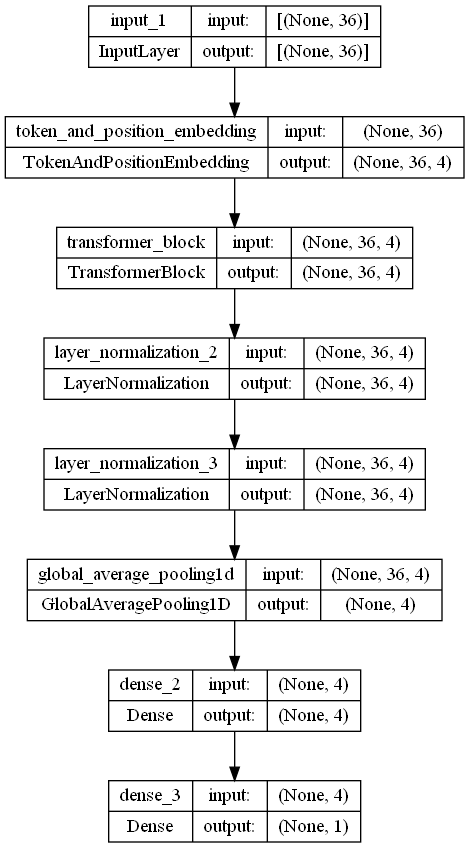

In [26]:
keras.backend.clear_session()
tf.random.set_seed(0)

#one transformer
embed_dim = 4  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 2  # Hidden layer size in feed forward network inside transformer

# create the input
inputs = layers.Input(shape=(max_length,))
# get our embeddings, note that we're using the embedding layer from above
embedding_layer = TokenAndPositionEmbedding(max_length, max_words, embed_dim)
x = embedding_layer(inputs)
# create a transformer layer and pass the embeddings through that.
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
# now we just want to classify the output of our transformer into positive or negative sentiment
# we can use a couple of dense layers to step down from our transformer output to our final classification
# decision
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(4, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()
plot_model(model, show_shapes=True)

In [27]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(opt, "binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_padded_X, y_train, batch_size=256, epochs=30, validation_data=(test_padded_X, y_test))

Epoch 1/30
328/328 [==============================] - 8s 18ms/step - loss: 0.6924 - accuracy: 0.5226 - val_loss: 0.6852 - val_accuracy: 0.5703
Epoch 2/30
328/328 [==============================] - 5s 17ms/step - loss: 0.6809 - accuracy: 0.5721 - val_loss: 0.6805 - val_accuracy: 0.5728
Epoch 3/30
328/328 [==============================] - 5s 16ms/step - loss: 0.6754 - accuracy: 0.5767 - val_loss: 0.6762 - val_accuracy: 0.5762
Epoch 4/30
328/328 [==============================] - 5s 17ms/step - loss: 0.6697 - accuracy: 0.5854 - val_loss: 0.6716 - val_accuracy: 0.5838
Epoch 5/30
328/328 [==============================] - 5s 17ms/step - loss: 0.6636 - accuracy: 0.5979 - val_loss: 0.6663 - val_accuracy: 0.5955
Epoch 6/30
328/328 [==============================] - 5s 17ms/step - loss: 0.6567 - accuracy: 0.6161 - val_loss: 0.6608 - val_accuracy: 0.6083
Epoch 7/30
328/328 [==============================] - 5s 16ms/step - loss: 0.6493 - accuracy: 0.6374 - val_loss: 0.6548 - val_accuracy: 0.6209

102/102 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

 D-relevant        0.80      0.82      0.81      1861
Not relevant       0.76      0.73      0.74      1402

    accuracy                           0.78      3263
   macro avg       0.78      0.78      0.78      3263
weighted avg       0.78      0.78      0.78      3263



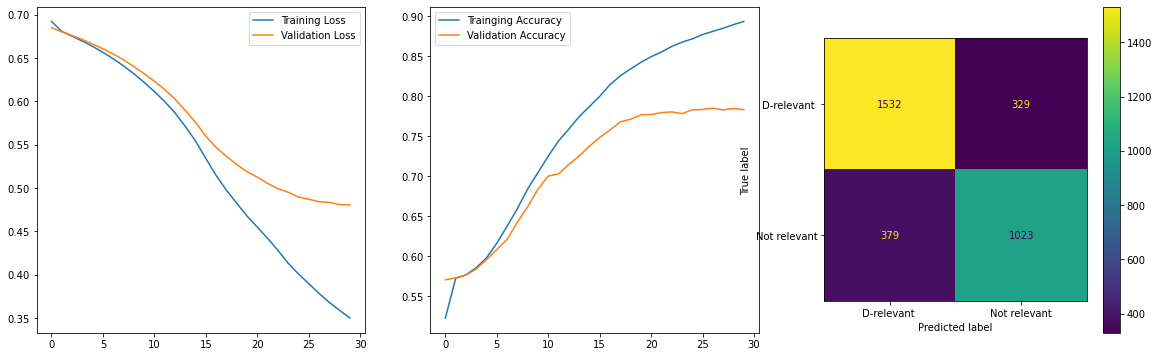

In [28]:
# measure model performance

fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 3, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.plot(history.history['accuracy'], label="Trainging Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend();

target_names = ['D-relevant ', 'Not relevant']
pred = model.predict(test_padded_X)
report = classification_report(y_test, pred.round(), target_names=target_names)
print(report)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(pred))
ax = fig.add_subplot(1, 3, 3)
c = ConfusionMatrixDisplay(confusion_matrix, display_labels = target_names)
c.plot(ax = ax)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36)]              0         
                                                                 
 token_and_position_embeddin  (None, 36, 4)            80144     
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 36, 4)            194       
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 36, 4)            194       
 ormerBlock)                                                     
                                                                 
 dense_4 (Dense)             (None, 36, 20)            100   

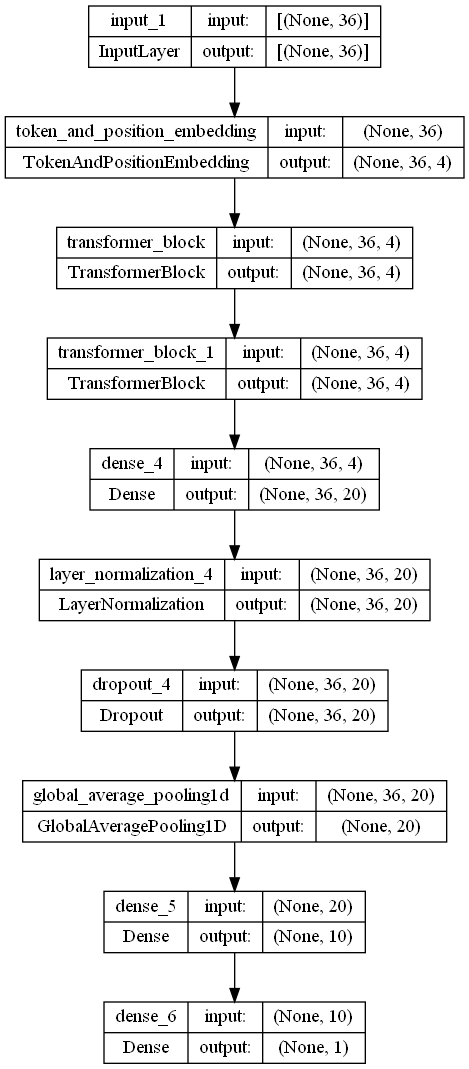

In [36]:
keras.backend.clear_session()
tf.random.set_seed(0)

#stacked transformer
embed_dim = 4  # Embedding size for each token
num_heads = 2  # Number of attention heads, note we've now made this 4
ff_dim = 2  # Hidden layer size in feed forward network inside transformer

# input layer
inputs = layers.Input(shape=(max_length,))
# embedding, again this is the token and position layer
embedding_layer = TokenAndPositionEmbedding(max_length, max_words, embed_dim)
x = embedding_layer(inputs)
# first transformer
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
# second transformer, takes the output of the first transformer as input
transformer_block_2 = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block_2(x)
# our classification block, as per the above
x = layers.Dense(20, activation="relu", kernel_regularizer='l2')(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.Dropout(0.1)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(10, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()
plot_model(model, show_shapes=True)

In [37]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(opt, "binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_padded_X, y_train, batch_size=256, epochs=35, validation_data=(test_padded_X, y_test))

Epoch 1/35
328/328 [==============================] - 14s 29ms/step - loss: 0.7585 - accuracy: 0.5566 - val_loss: 0.7532 - val_accuracy: 0.5679
Epoch 2/35
328/328 [==============================] - 9s 27ms/step - loss: 0.7539 - accuracy: 0.5637 - val_loss: 0.7497 - val_accuracy: 0.5703
Epoch 3/35
328/328 [==============================] - 9s 26ms/step - loss: 0.7494 - accuracy: 0.5676 - val_loss: 0.7458 - val_accuracy: 0.5755
Epoch 4/35
328/328 [==============================] - 9s 26ms/step - loss: 0.7446 - accuracy: 0.5724 - val_loss: 0.7412 - val_accuracy: 0.5777
Epoch 5/35
328/328 [==============================] - 9s 27ms/step - loss: 0.7392 - accuracy: 0.5792 - val_loss: 0.7356 - val_accuracy: 0.5841
Epoch 6/35
328/328 [==============================] - 9s 28ms/step - loss: 0.7320 - accuracy: 0.5915 - val_loss: 0.7285 - val_accuracy: 0.6019
Epoch 7/35
328/328 [==============================] - 9s 27ms/step - loss: 0.7227 - accuracy: 0.6112 - val_loss: 0.7190 - val_accuracy: 0.617

102/102 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

 D-relevant        0.78      0.86      0.82      1861
Not relevant       0.79      0.67      0.72      1402

    accuracy                           0.78      3263
   macro avg       0.78      0.77      0.77      3263
weighted avg       0.78      0.78      0.78      3263



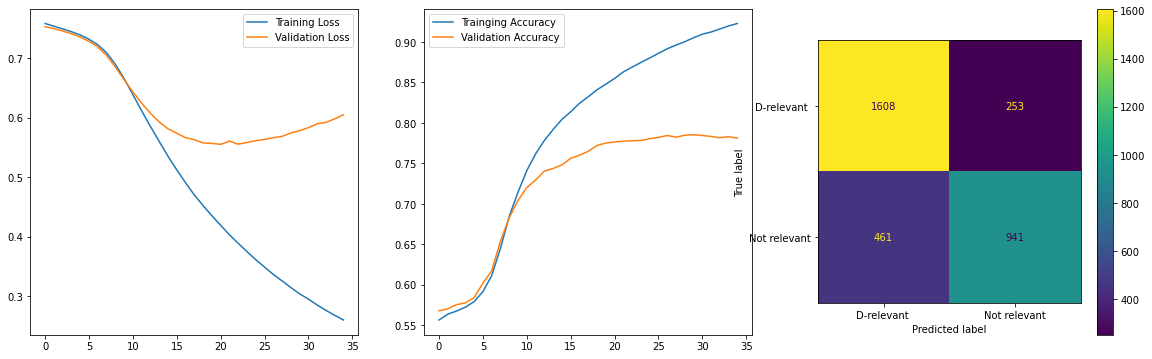

In [38]:
# measure model performance

fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 3, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.legend()

ax = fig.add_subplot(1, 3, 2)
ax.plot(history.history['accuracy'], label="Trainging Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.legend();

target_names = ['D-relevant ', 'Not relevant']
pred = model.predict(test_padded_X)
report = classification_report(y_test, pred.round(), target_names=target_names)
print(report)

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, np.rint(pred))
ax = fig.add_subplot(1, 3, 3)
c = ConfusionMatrixDisplay(confusion_matrix, display_labels = target_names)
c.plot(ax = ax)